# Para ejecutar en Google Colab en Drive

In [ ]:
# Montamos el Drive al Notebook
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
# Verificamos el directorio en el que nos encontramos
!pwd
!ls

In [ ]:
# Cambiamos de directorio al Drive
# TODO: change path
import os
os.chdir("drive/My Drive/PruebasCOLAB4/trajpred-bdl/tests")
!ls

# Inicio de Código

In [1]:
# Imports
import time
import sys,os,logging, argparse
''' TF_CPP_MIN_LOG_LEVEL
0 = all messages are logged (default behavior)
1 = INFO messages are not printed
2 = INFO and WARNING messages are not printeds
3 = INFO, WARNING, and ERROR messages are not printed
'''
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
sys.path.append('../bayesian-torch')
sys.path.append('../OF-PathPred')
sys.path.append('..')

import math,numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torchvision import transforms
import torch.optim as optim

# Local models
from models.bayesian_models_gaussian_loss import lstm_encdec
from utils.datasets_utils import Experiment_Parameters, setup_loo_experiment, traj_dataset
from utils.plot_utils import plot_traj
from utils.calibration import calibration
from utils.calibration import miscalibration_area, mean_absolute_calibration_error, root_mean_squared_calibration_error

In [2]:
logging.basicConfig(format='%(levelname)s: %(message)s',level=20)
# GPU
if torch.cuda.is_available():
    logging.info(torch.cuda.get_device_name(torch.cuda.current_device()))


In [3]:
# Load the default parameters
experiment_parameters = Experiment_Parameters(add_kp=False,obstacles=False)

dataset_dir   = "../OF-PathPred/datasets/"
dataset_names = ['eth-hotel','eth-univ','ucy-zara01','ucy-zara02','ucy-univ']
idTest        = 2
pickle        = False

# parameters models
num_epochs     = 20
initial_lr     = 0.00003
batch_size     = 64
num_ensembles = 5
band_train = True


In [4]:
# Load the dataset and perform the split
training_data, validation_data, test_data, test_homography = setup_loo_experiment('ETH_UCY',dataset_dir,dataset_names,idTest,experiment_parameters,pickle_dir='../pickle',use_pickled_data=pickle)

INFO: Testing/validation dataset: ['ucy-zara01']
INFO: Training datasets: ['eth-hotel', 'eth-univ', 'ucy-zara02', 'ucy-univ']
INFO: Unpickling...
INFO: Training data: 15481
INFO: Test data: 2356
INFO: Validation data: 1720


In [5]:
# Creamos el dataset para torch
train_data = traj_dataset(training_data['obs_traj_rel'], training_data['pred_traj_rel'],training_data['obs_traj'], training_data['pred_traj'])
val_data = traj_dataset(validation_data['obs_traj_rel'], validation_data['pred_traj_rel'],validation_data['obs_traj'], validation_data['pred_traj'])
test_data = traj_dataset(test_data['obs_traj_rel'], test_data['pred_traj_rel'], test_data['obs_traj'], test_data['pred_traj'])

In [6]:
# Form batches
batched_train_data = torch.utils.data.DataLoader( train_data, batch_size = batch_size, shuffle=False)
batched_val_data =  torch.utils.data.DataLoader( val_data, batch_size = batch_size, shuffle=False)
batched_test_data =  torch.utils.data.DataLoader( test_data, batch_size = batch_size, shuffle=False)

## Entrenamos el modelo

In [7]:
import torch.optim as optim

# Función para entrenar los modelos
def train(model):
    # Training the Model
    optimizer = optim.SGD(model.parameters(), lr=initial_lr)

    list_loss_train = []
    list_loss_val = []
    for epoch in range(num_epochs):
        # Training
        print("----- ")
        print("epoch: ", epoch)
        error = 0
        total = 0
        # Recorremos cada batch
        for batch_idx, (data, target, data_abs , target_abs) in enumerate(batched_train_data):
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()
            if torch.cuda.is_available():
              data  = data.to(device)
              target=target.to(device)
              data_abs  = data_abs.to(device)
              target_abs=target_abs.to(device)

            # Step 2. Run our forward pass and compute the loss
            loss = model(data, target, data_abs , target_abs)# , training=True)
            error += loss
            total += len(target)

            # Step 3. Compute the gradients, and update the parameters by
            loss.backward()
            optimizer.step()
        print("training loss: ", error/total)
        list_loss_train.append(error.detach().cpu().numpy()/total)

        # Validation
        error = 0
        total = 0
        for batch_idx, (data_val, target_val, data_abs , target_abs) in enumerate(batched_val_data):

            if torch.cuda.is_available():
              data_val  = data_val.to(device)
              target_val = target_val.to(device)
              data_abs  = data_abs.to(device)
              target_abs = target_abs.to(device)

            loss_val = model(data_val, target_val, data_abs , target_abs)
            error += loss_val
            total += len(target_val)

        print("Validation loss: ", error/total)
        list_loss_val.append(error.detach().cpu().numpy()/total)

    # Visualizamos los errores
    plt.figure(figsize=(12,12))
    plt.plot(list_loss_train, label="loss train")
    plt.plot(list_loss_val, label="loss val")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    

In [8]:
# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Seleccionamos de forma aleatorea las semillas
seeds = np.random.choice(99999999, num_ensembles , replace=False)
print("Semillas: ", seeds)

Semillas:  [94259657 59772448 20565804 57025222 75641498]


In [9]:
if band_train:
    # Entrenamos el modelo para cada semilla
    for ind, seed in enumerate(seeds):
        # Agregamos la semilla
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)

        # Instanciamos el modelo
        model = lstm_encdec(2,128,256,2)
        model.to(device)

        # Entremamos el modelo
        print("\n*** Entrenando para seed: ", seed, "\t\t ", ind, "/",len(seeds))
        train(model)

        plt.savefig("images/loss_"+str(ind)+"_"+str(idTest)+".pdf")
        plt.show()

        # Guardamos el Modelo
        torch.save(model.state_dict(), "../training_checkpoints/model_deterministic_"+str(ind)+"_"+str(idTest)+".pth")
        

## Visualizamos las predicciones

In [10]:
# Instanciamos el modelo
model = lstm_encdec(2,128,256,2)
model.to(device)

lstm_encdec(
  (embedding): Linear(in_features=2, out_features=128, bias=True)
  (lstm1): LSTM(128, 256)
  (lstm2): LSTM(128, 256)
  (decoder): Linear(in_features=256, out_features=5, bias=True)
)

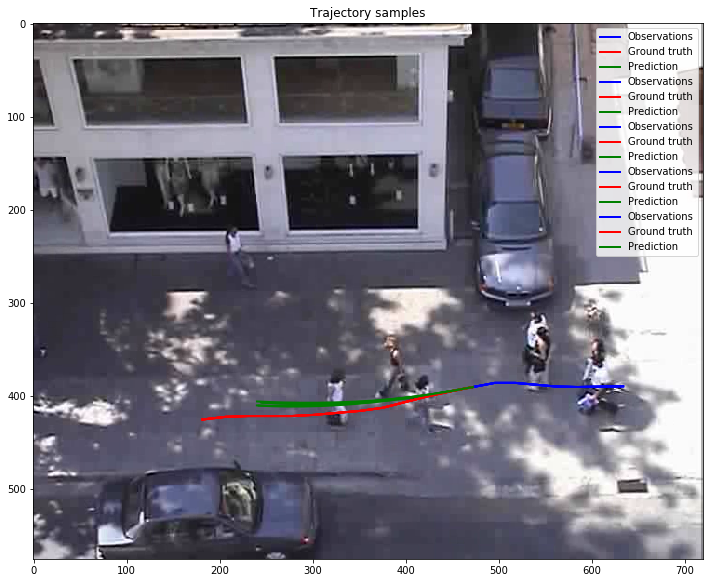

In [11]:
ind_sample = 1
bck = plt.imread(os.path.join(dataset_dir,dataset_names[idTest],'reference.png'))

# Testing
for batch_idx, (datarel_test, targetrel_test, data_test, target_test) in enumerate(batched_test_data):
    
    plt.figure(figsize=(12,12))
    plt.imshow(bck)

    param_gaussiana = []

    # prediction
    for ind in range(num_ensembles):

        # Cargamos el Modelo
        model.load_state_dict(torch.load("../training_checkpoints/model_deterministic_"+str(ind)+"_"+str(idTest)+".pth"))
        model.eval()

        if torch.cuda.is_available():
              datarel_test  = datarel_test.to(device)

        pred, sigmas = model.predict(datarel_test, dim_pred=12)

        # ploting
        plot_traj(pred[ind_sample,:,:], data_test[ind_sample,:,:], target_test[ind_sample,:,:], test_homography, bck)
    plt.legend()
    plt.title('Trajectory samples')
    plt.show()
    # Solo aplicamos a un elemento del batch
    break


## Calibramos la incertidumbre

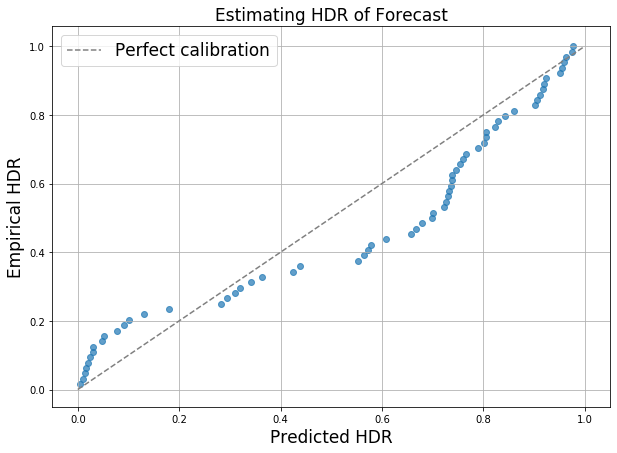

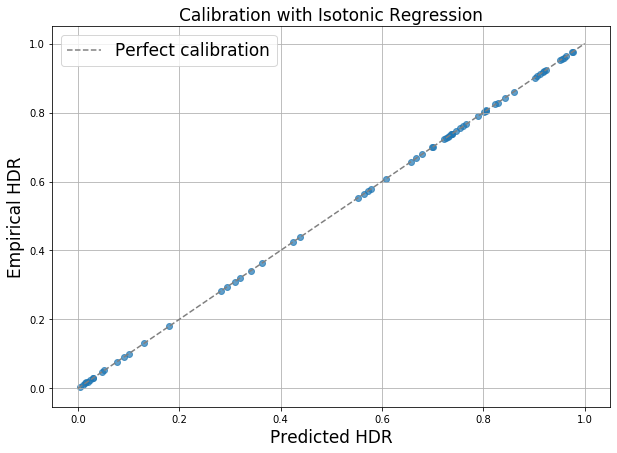

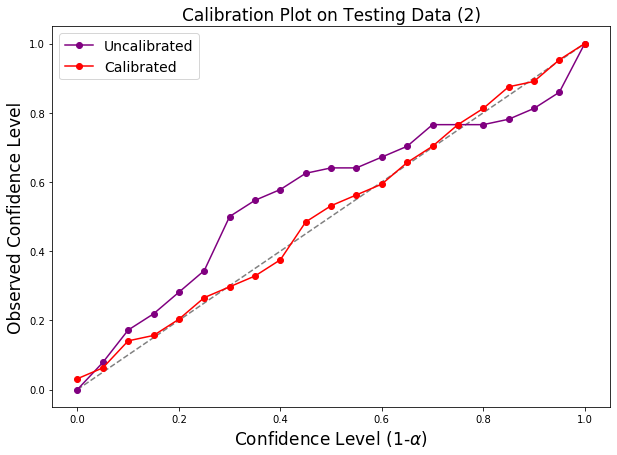

                  area
Uncalibrated  0.090625
Calibrated    0.015156


In [12]:
draw_ellipse = True

# Testing
cont = 0
for batch_idx, (datarel_test, targetrel_test, data_test, target_test) in enumerate(batched_test_data):
    
    tpred_samples = []
    sigmas_samples = []
    # Muestreamos con cada modelo
    for ind in range(num_ensembles):

        # Cargamos el Modelo
        model.load_state_dict(torch.load("../training_checkpoints/model_deterministic_"+str(ind)+"_"+str(idTest)+".pth"))
        model.eval()

        if torch.cuda.is_available():
              datarel_test  = datarel_test.to(device)

        pred, sigmas = model.predict(datarel_test, dim_pred=12)

        tpred_samples.append(pred)
        sigmas_samples.append(sigmas)

    plt.show()
    
    tpred_samples = np.array(tpred_samples)
    sigmas_samples = np.array(sigmas_samples)

    # HDR y Calibracion
    auc_cal, auc_unc, exp_proportions, obs_proportions_unc, obs_proportions_cal = calibration(tpred_samples, data_test, target_test, sigmas_samples, position = 11, alpha = 0.05, idTest=idTest)
    plt.show()

    # Solo se ejecuta para un batch
    break


## Metrics Calibration

In [13]:
ma1 = miscalibration_area(exp_proportions, obs_proportions_unc)
mace1 = mean_absolute_calibration_error(exp_proportions, obs_proportions_unc)
rmsce1 = root_mean_squared_calibration_error(exp_proportions, obs_proportions_unc)

print("Before Recalibration:  ", end="")
print("MACE: {:.5f}, RMSCE: {:.5f}, MA: {:.5f}".format(mace1, rmsce1, ma1))

Before Recalibration:  MACE: 0.08631, RMSCE: 0.10454, MA: 0.09009


In [14]:
ma2 = miscalibration_area(exp_proportions, obs_proportions_cal)
mace2 = mean_absolute_calibration_error(exp_proportions, obs_proportions_cal)
rmsce2 = root_mean_squared_calibration_error(exp_proportions, obs_proportions_cal)

print("After Recalibration:  ", end="")
print("MACE: {:.5f}, RMSCE: {:.5f}, MA: {:.5f}".format(mace2, rmsce2, ma2))

After Recalibration:  MACE: 0.01518, RMSCE: 0.01917, MA: 0.01348


In [15]:
df = pd.DataFrame([["","MACE","RMSCE","MA"],["Before Recalibration", mace1, rmsce1, ma1],["After Recalibration", mace2, rmsce2, ma2]])
df.to_csv("images/metrics_calibration_"+str(idTest)+".csv")